<a href="https://colab.research.google.com/github/filmerxyz/Skin_Detection/blob/master/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [1]:
!pip install split-folders
!pip install Augmentor

# Import Libraries

In [0]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import itertools

import split_folders
import Augmentor

import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import shutil
import random

# Clone Data

In [3]:
!git clone https://github.com/filmerxyz/SKIN_DATA

Cloning into 'SKIN_DATA'...
remote: Enumerating objects: 480, done.
remote: Counting objects: 100% (480/480), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 922 (delta 217), reused 393 (delta 132), pack-reused 442
Receiving objects: 100% (922/922), 113.50 MiB | 48.25 MiB/s, done.
Resolving deltas: 100% (255/255), done.
Checking out files: 100% (1817/1817), done.


# Define Functions

In [0]:
def mkdir_folder(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)
        print("Directory " , dir,  " Created ")
    else:    
        print("Directory " , dir,  " already exists")

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Make a Folder

In [6]:
mkdir_folder('/content/data_folder')

Directory  /content/data_folder  Created 


# Split Data

In [7]:
split_folders.ratio('/content/SKIN_DATA/crop_classes_data', 
                    output='/content/data_folder', 
                    seed=1337, 
                    ratio=(0.8, 0.1, 0.1)) #train=0.8, val=0.1, test=0.1

Copying files: 224 files [00:00, 2693.32 files/s]


# Directories

In [0]:
train_dir = '/content/data_folder/train'
val_dir = '/content/data_folder/val'
test_dir = '/content/data_folder/test'

# Data Visualization

In [0]:
ad_dir = '/content/data_folder/train/AtopicDermatitis'
pv_dir = '/content/data_folder/train/PsoriasisVulgaris'
sk_dir = '/content/data_folder/train/SeborrhoeicKeratosis'
vt_dir = '/content/data_folder/train/Vitiligo'

In [0]:
# plotImages(val_dir[:5])

# Parameters

In [0]:
img_size = 224
epochs = 100
batch_size = 32

# Data Augmentation

In [0]:
root_directory = '/content/data_folder/train/*'

In [13]:
folders = []
for f in glob.glob(root_directory):
    if os.path.isdir(f):
        folders.append(os.path.abspath(f))

print("Folders (classes) found: %s " % [os.path.split(x)[1] for x in folders])

Folders (classes) found: ['Vitiligo', 'SeborrhoeicKeratosis', 'AtopicDermatitis', 'PsoriasisVulgaris'] 


In [14]:
pipelines = {}
for folder in folders:
    print("Folder %s:" % (folder))
    pipelines[os.path.split(folder)[1]] = (Augmentor.Pipeline(folder))
    print("\n----------------------------\n")

Folder /content/data_folder/train/Vitiligo:
Initialised with 19 image(s) found.
Output directory set to /content/data_folder/train/Vitiligo/output.
----------------------------

Folder /content/data_folder/train/SeborrhoeicKeratosis:
Initialised with 45 image(s) found.
Output directory set to /content/data_folder/train/SeborrhoeicKeratosis/output.
----------------------------

Folder /content/data_folder/train/AtopicDermatitis:
Initialised with 52 image(s) found.
Output directory set to /content/data_folder/train/AtopicDermatitis/output.
----------------------------

Folder /content/data_folder/train/PsoriasisVulgaris:
Initialised with 62 image(s) found.
Output directory set to /content/data_folder/train/PsoriasisVulgaris/output.
----------------------------



In [15]:
for p in pipelines.values():
    print("Class %s has %s samples." % (p.augmentor_images[0].class_label, len(p.augmentor_images)))

Class Vitiligo has 19 samples.
Class SeborrhoeicKeratosis has 45 samples.
Class AtopicDermatitis has 52 samples.
Class PsoriasisVulgaris has 62 samples.


In [16]:
for train_aug in pipelines.values():
    train_aug.rotate(probability=1, max_left_rotation=25, max_right_rotation=25)
    train_aug.flip_left_right(probability=0.5)
    train_aug.flip_top_bottom(probability=0.5)
    train_aug.zoom_random(probability=0.5, percentage_area=0.8)
    #train_aug.status()
    train_aug.sample(300)

Processing <PIL.Image.Image image mode=RGB size=278x389 at 0x7F6EE8210390>: 100%|██████████| 300/300 [00:12<00:00, 24.13 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1640x1122 at 0x7F6EE3190898>: 100%|██████████| 300/300 [01:01<00:00,  4.88 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=390x258 at 0x7F6EE31AAB00>: 100%|██████████| 300/300 [00:11<00:00, 26.20 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=550x518 at 0x7F6EE82189B0>: 100%|██████████| 300/300 [00:10<00:00, 27.45 Samples/s]


# Rename Folders

In [0]:
ad_aug_dir = os.rename('/content/data_folder/train/AtopicDermatitis/output', '/content/data_folder/train/AtopicDermatitis/ad_aug_dir')
pv_aug_dir = os.rename('/content/data_folder/train/PsoriasisVulgaris/output', '/content/data_folder/train/PsoriasisVulgaris/pv_aug_dir')
sk_aug_dir = os.rename('/content/data_folder/train/SeborrhoeicKeratosis/output', '/content/data_folder/train/SeborrhoeicKeratosis/sk_aug_dir')
vt_aug_dir = os.rename('/content/data_folder/train/Vitiligo/output', '/content/data_folder/train/Vitiligo/vt_aug_dir')

In [0]:
ad_aug_dir = '/content/data_folder/train/AtopicDermatitis/ad_aug_dir'
pv_aug_dir = '/content/data_folder/train/PsoriasisVulgaris/pv_aug_dir'
sk_aug_dir = '/content/data_folder/train/SeborrhoeicKeratosis/sk_aug_dir'
vt_aug_dir = '/content/data_folder/train/Vitiligo/vt_aug_dir'

In [19]:
print(len(os.listdir(ad_aug_dir)))
print(len(os.listdir(pv_aug_dir)))
print(len(os.listdir(sk_aug_dir)))
print(len(os.listdir(vt_aug_dir)))

300
300
300
300


In [20]:
mkdir_folder('/content/data_folder/train_aug')

Directory  /content/data_folder/train_aug  Created 


In [0]:
train_aug_dir = '/content/data_folder/train_aug/'

In [22]:
shutil.move(ad_aug_dir, train_aug_dir)
shutil.move(pv_aug_dir, train_aug_dir)
shutil.move(sk_aug_dir, train_aug_dir)
shutil.move(vt_aug_dir, train_aug_dir)

'/content/data_folder/train_aug/vt_aug_dir'

In [0]:
train_gen = ImageDataGenerator(rescale=1. / 255)

val_gen = ImageDataGenerator(rescale=1. / 255)

test_gen = ImageDataGenerator(rescale=1. / 255)

In [24]:
train_datagen = train_gen.flow_from_directory(batch_size=batch_size,
                                          directory=train_aug_dir,
                                          shuffle=True,
                                          target_size=(img_size, img_size), #(224,224)
                                          class_mode='categorical')
val_datagen = val_gen.flow_from_directory(batch_size=batch_size,
                                          directory=val_dir,
                                          shuffle=True,
                                          target_size=(img_size, img_size), #(224,224)
                                          class_mode='categorical')
test_datagen = test_gen.flow_from_directory(batch_size=batch_size,
                                          directory=test_dir,
                                          shuffle=False,
                                          target_size=(img_size, img_size), #(224,224)
                                          class_mode='categorical')

Found 1200 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Found 26 images belonging to 4 classes.


In [0]:
sample_training_images, _ = next(train_datagen)

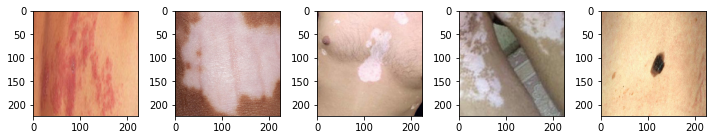

In [26]:
plotImages(sample_training_images[:5])

In [27]:
num_train_files = len(train_datagen.filenames)
num_train_classes = len(train_datagen.class_indices)
print('num_train_files', num_train_files, '&', 'num_train_classes', num_train_classes )

num_val_files = len(val_datagen.filenames)
num_val_classes = len(val_datagen.class_indices)
print('num_val_files', num_val_files, '&', 'num_val_classes', num_val_classes )

num_test_files = len(test_datagen.filenames)
num_test_classes = len(test_datagen.class_indices)
print('num_test_files', num_test_files, '&', 'num_test_classes', num_test_classes )

num_train_files 1200 & num_train_classes 4
num_val_files 20 & num_val_classes 4
num_test_files 26 & num_test_classes 4


In [0]:
train_steps = np.ceil(num_train_files/batch_size)
val_steps = np.ceil(num_val_files/batch_size)

# Base model


In [0]:
base_model = tf.keras.applications.nasnet.NASNetLarge(input_shape=(224, 224, 3), include_top=False, weights=None)

In [0]:
base_model.trainable = False

In [0]:
#base_model.summary()

In [32]:
len(base_model.layers)

1039

# Head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [0]:
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
prediction_layer = tf.keras.layers.Dense(units=4, activation='softmax')(average_pooling_layer)

In [0]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [0]:
#model.summary()

In [36]:
len(model.layers)

1041

# Compile

In [0]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
#                              save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
# log_dir = '/content/drive/My Drive/โครงงานผื่น/PJ61403/implementation/CNN/NASNetMobile/tf-log/'
# tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

In [0]:
cb_list = [early_stop]

# Train

In [42]:
history = model.fit(train_datagen,
                    steps_per_epoch=train_steps,
                    validation_data=val_datagen,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=cb_list)

Epoch 1/100
38/38 [==============================] - 25s 661ms/step - loss: 1.3798 - accuracy: 0.3600 - val_loss: 2.6522 - val_accuracy: 0.2500
Epoch 2/100
38/38 [==============================] - 19s 505ms/step - loss: 1.0290 - accuracy: 0.5900 - val_loss: 6.4513 - val_accuracy: 0.3000
Epoch 3/100
38/38 [==============================] - 19s 506ms/step - loss: 0.8438 - accuracy: 0.6950 - val_loss: 5.9064 - val_accuracy: 0.3000
Epoch 4/100
38/38 [==============================] - 19s 506ms/step - loss: 0.8144 - accuracy: 0.6733 - val_loss: 8.0317 - val_accuracy: 0.3000
Epoch 5/100
38/38 [==============================] - 19s 508ms/step - loss: 0.7357 - accuracy: 0.7300 - val_loss: 7.3509 - val_accuracy: 0.3000
Epoch 6/100
38/38 [==============================] - 19s 507ms/step - loss: 0.6871 - accuracy: 0.7525 - val_loss: 8.2263 - val_accuracy: 0.3000
Epoch 7/100
38/38 [==============================] - 19s 509ms/step - loss: 0.6564 - accuracy: 0.7567 - val_loss: 8.9396 - val_accuracy:

# Google Drive

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

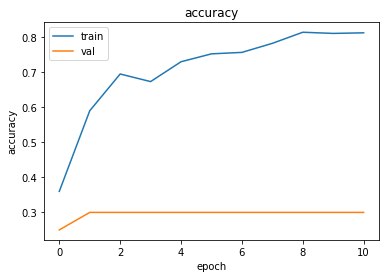

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

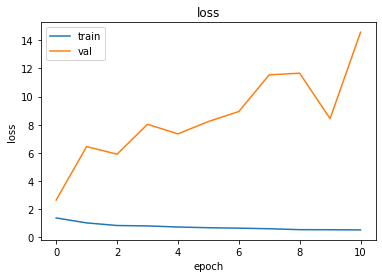

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

In [54]:
test_labels = test_datagen.classes
predictions = model.predict_generator(test_datagen, steps=val_steps, verbose=1)

1/1 [==============================] - 0s 1ms/step


Confusion matrix, without normalization
[[7 0 0 0]
 [9 0 0 0]
 [7 0 0 0]
 [3 0 0 0]]


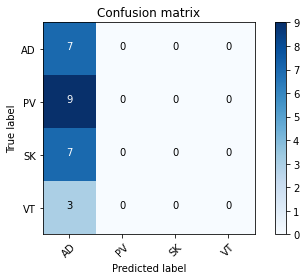

In [57]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['AD', 'PV', 'SK', 'VT']

plot_confusion_matrix(cm, cm_plot_labels)

In [59]:
Y_pred = model.predict_generator(test_datagen, num_test_files//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_datagen.classes, y_pred))
print('Classification Report')
classes_names = ['AD', 'PV', 'SK', 'VT']
print(classification_report(test_datagen.classes, y_pred, target_names=classes_names))

Confusion Matrix
[[7 0 0 0]
 [9 0 0 0]
 [7 0 0 0]
 [3 0 0 0]]
Classification Report
              precision    recall  f1-score   support

          AD       0.27      1.00      0.42         7
          PV       0.00      0.00      0.00         9
          SK       0.00      0.00      0.00         7
          VT       0.00      0.00      0.00         3

    accuracy                           0.27        26
   macro avg       0.07      0.25      0.11        26
weighted avg       0.07      0.27      0.11        26



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
